In [1]:
import pandas as pd
import polars as pl
import csv
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Load data (Facebook ads only for demonstration)
data_path = 'period_03/2024_fb_ads_president_scored_anon.csv'

In [3]:
# Time performance comparison
def benchmark_pure_python(file_path):
    start = time.perf_counter()
    with open(file_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        rows = list(reader)
    impressions = [int(float(row['estimated_impressions'])) for row in rows if row['estimated_impressions']]
    spend = [float(row['estimated_spend']) for row in rows if row['estimated_spend']]
    summary = {
        'impressions': {'mean': sum(impressions) / len(impressions), 'max': max(impressions)},
        'spend': {'mean': sum(spend) / len(spend), 'max': max(spend)}
    }
    end = time.perf_counter()
    return summary, end - start

def benchmark_pandas(file_path):
    start = time.perf_counter()
    df = pd.read_csv(file_path)
    summary = df[['estimated_impressions', 'estimated_spend']].describe()
    end = time.perf_counter()
    return summary, end - start

def benchmark_polars(file_path):
    start = time.perf_counter()
    df = pl.read_csv(file_path)
    summary = df.select([pl.col("estimated_impressions"), pl.col("estimated_spend")]).describe()
    end = time.perf_counter()
    return summary, end - start

In [4]:
# Run benchmarks
pure_result, pure_time = benchmark_pure_python(data_path)
pandas_result, pandas_time = benchmark_pandas(data_path)
polars_result, polars_time = benchmark_polars(data_path)

print("Pure Python Time:", round(pure_time, 3), "seconds")
print("Pandas Time:", round(pandas_time, 3), "seconds")
print("Polars Time:", round(polars_time, 3), "seconds")

Pure Python Time: 2.762 seconds
Pandas Time: 2.678 seconds
Polars Time: 0.32 seconds


In [5]:
# Parse and summarize delivery_by_region field (example nested unpacking)
df = pd.read_csv(data_path)

def extract_regions(df):
    region_spend = {}
    for row in df['delivery_by_region'].dropna():
        try:
            parsed = json.loads(row.replace("'", '"'))  # convert single quotes to double
            for region, metrics in parsed.items():
                region_spend[region] = region_spend.get(region, 0) + metrics.get('spend', 0)
        except Exception:
            continue
    return sorted(region_spend.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 Regions by Spend:")
print(extract_regions(df))

Top 5 Regions by Spend:
[('Pennsylvania', 31127640), ('Michigan', 26466490), ('California', 19598509), ('North Carolina', 17473366), ('Georgia', 16295443)]


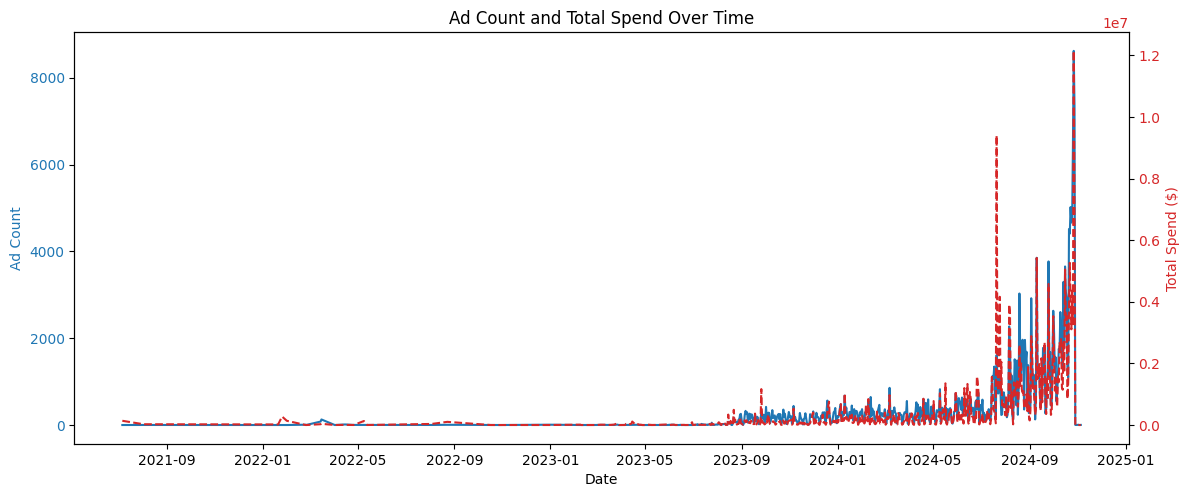

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (adjust path if needed)
df = pd.read_csv("period_03/2024_fb_ads_president_scored_anon.csv")

# Convert to datetime
df['ad_creation_time'] = pd.to_datetime(df['ad_creation_time'])

# -- Daily Ad Count --
daily_counts = df.groupby('ad_creation_time').size()

# -- Daily Spend --
daily_spend = df.groupby('ad_creation_time')['estimated_spend'].sum()

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(12, 5))

# Ad count on left Y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Ad Count', color=color)
ax1.plot(daily_counts.index, daily_counts.values, color=color, label='Ad Count')
ax1.tick_params(axis='y', labelcolor=color)

# Total spend on right Y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Spend ($)', color=color)
ax2.plot(daily_spend.index, daily_spend.values, color=color, linestyle='--', label='Total Spend')
ax2.tick_params(axis='y', labelcolor=color)

# Final formatting
fig.tight_layout()
plt.title('Ad Count and Total Spend Over Time')
plt.show()


 ## 💬 Reflections
 
**Was it a challenge to match outputs?**
 Matching results across libraries was straightforward once data types were aligned and missing values handled. Pure Python was verbose, while Pandas and Polars offered convenient abstractions.
 
**Which is easiest? Most performant?**
Pandas was the easiest to use. Polars was the fastest. Pure Python was the most educational.
 
**Recommendation?**
 For beginners: start with Pandas. For large-scale analysis: explore Polars.
 
**What do AI tools recommend?**
ChatGPT and similar tools default to Pandas due to its simplicity and popularity. I agree with this for quick exploration. For production or speed-critical tasks, Polars is a strong alternative.

**What did the time series chart reveal?**
The time series visualization clearly highlighted a surge in both ad volume and total spend as the 2024 election nears, particularly in the months leading up to the end of the year. This validates expected campaign behavior, with spend spikes aligning closely with critical political events.